# 37

In [1]:
# 관련 라이브러리 설치
# datasets==1.4.1 버전을 설치해야 함에 유의
!pip install datasets==1.4.1
!pip install transformers
!pip install soundfile
!pip install jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.8/186.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.7 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.4
    Uninstalling tqdm-4.66.4:
      Successfully uninstalled tqdm-4.66.4
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.23.5
    Uninstalling huggingface-hub-0.23.5:
      Successfully uninstalled huggingface-hub-0.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopami

### Wave2Vec2
[논문](https://ar5iv.labs.arxiv.org/html/2012.12121)

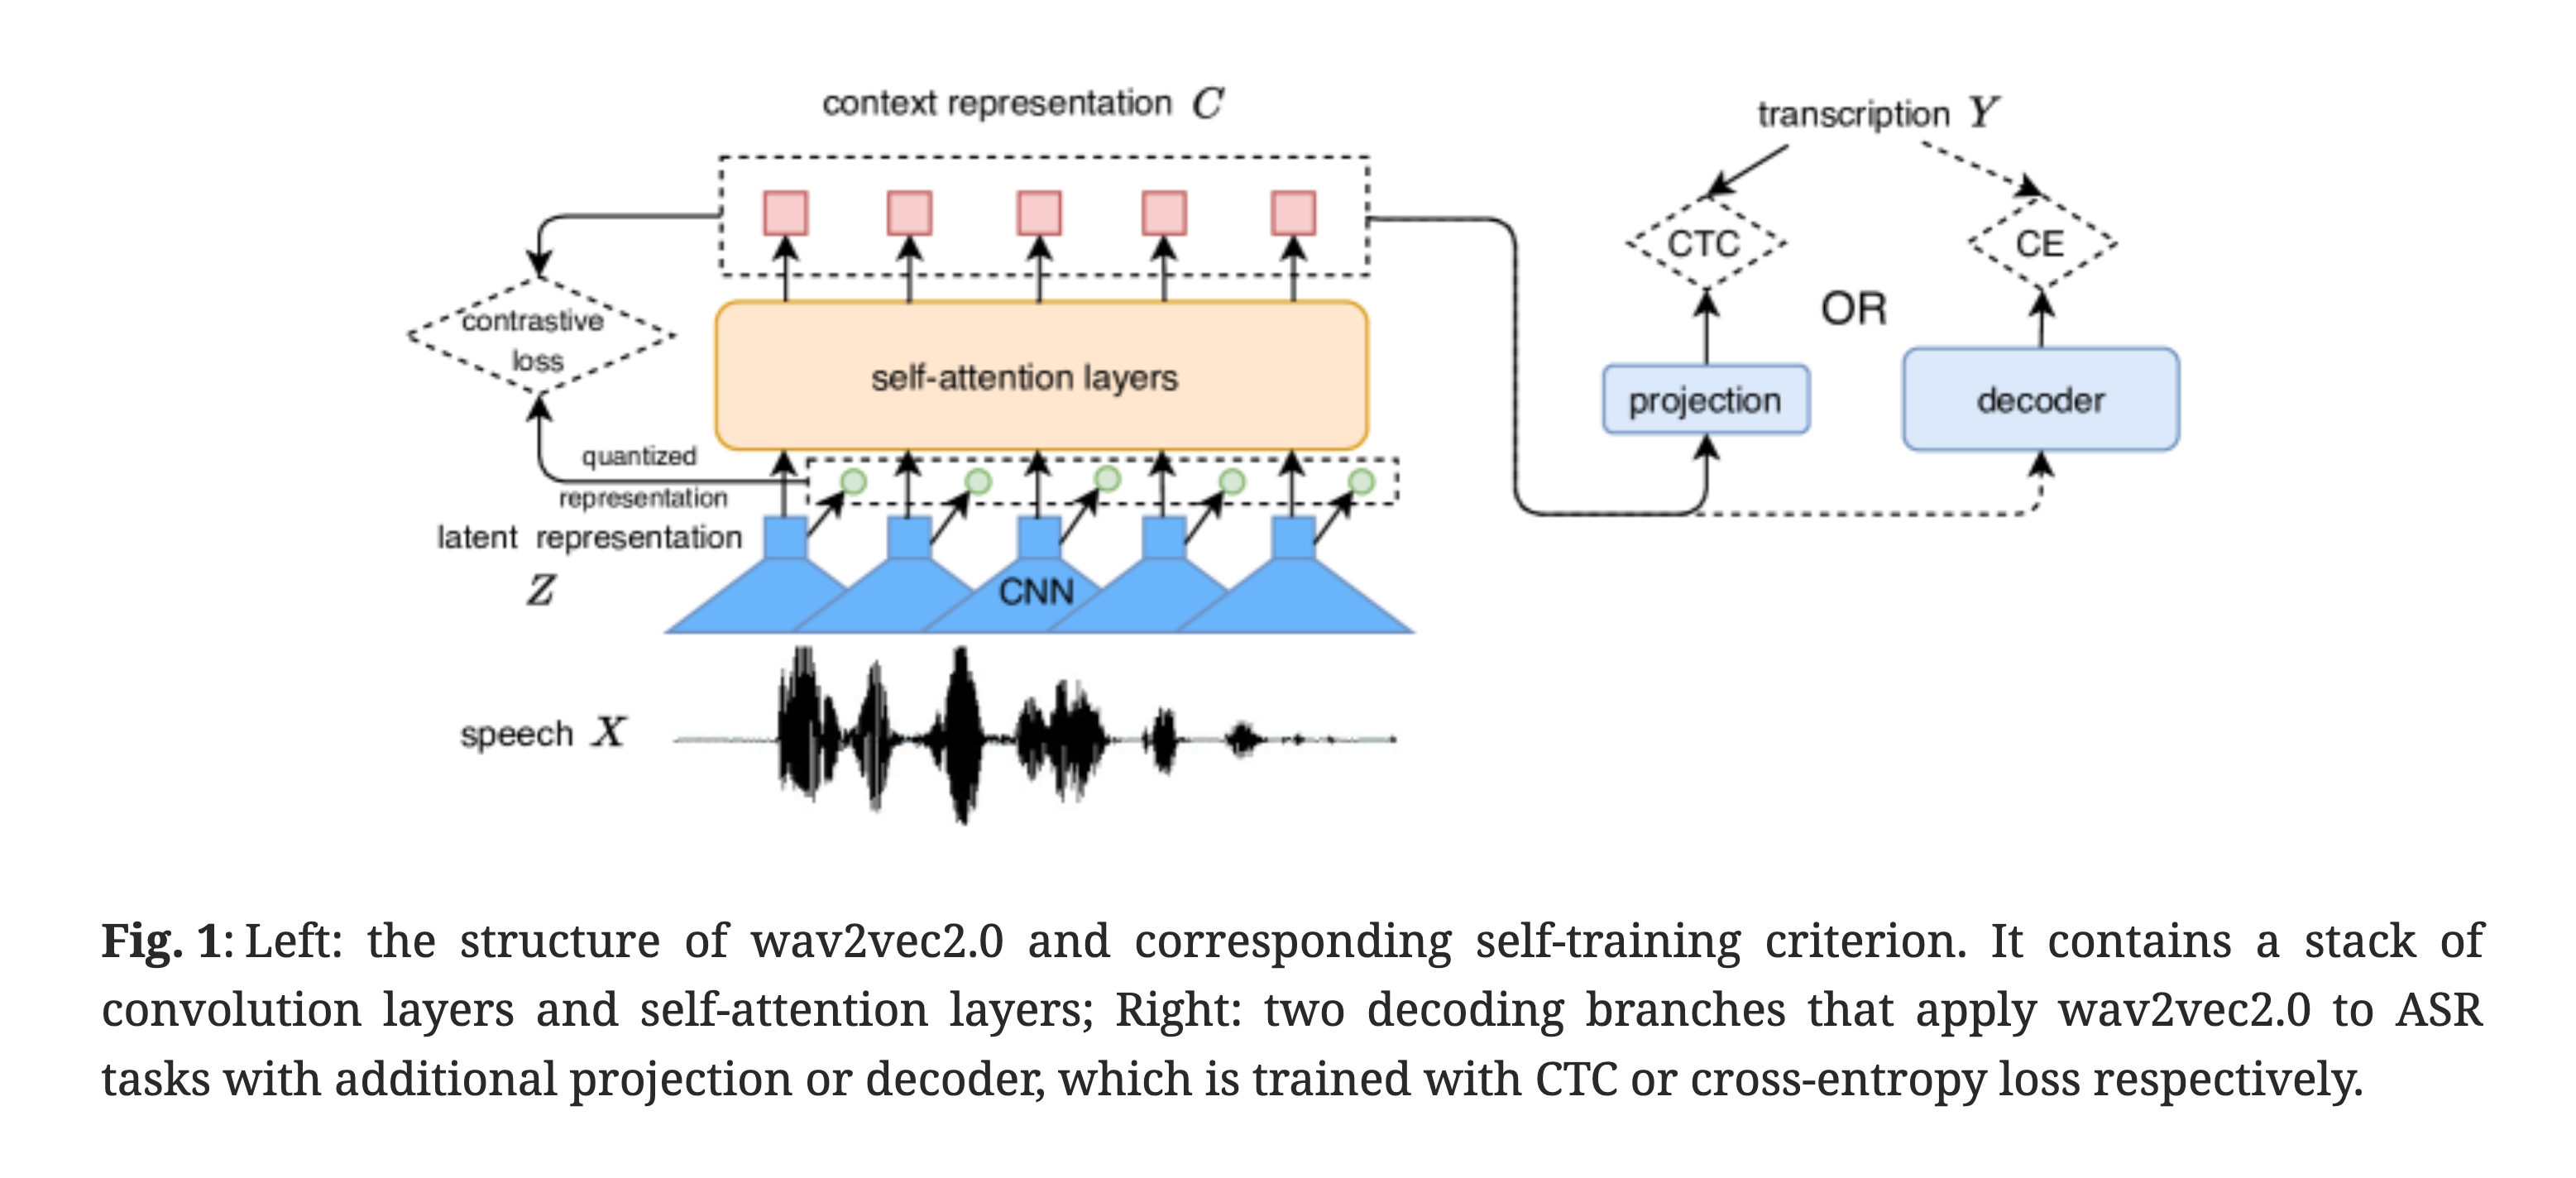

#38

## Wave2Vec2 각 로스 함수
1.대비 손실 (Contrastive Loss)
**목적:**
대비 손실은 자가 지도 학습(self-supervised learning) 단계에서 사용. 이 손실 함수는 모델이 레이블이 없는 대규모 음성 데이터에서 유용한 특징을 학습할 수 있도록 함.

**단계**:

- 특징 추출: CNN 기반 특성 추출기에서 음성 신호 𝑋를 통해 잠재 표현 𝑍를 추출.
- 양자화된 표현: 잠재 표현 𝑍를 벡터 양자화(vector quantization)하여 양자화된 표현을 생성.
- 컨텍스트 표현: 양자화된 표현은 self-attention 레이어를 통해 문맥 표현(context representation) 𝐶로 변환.

**대비 손실 적용:**
- 양자화된 표현과 문맥 표현 사이에서 contrastive loss를 계산하여, 문맥 표현이 원본 음성 신호의 특징을 잘 보존하도록 학습.
- 대비 손실은 양자화된 표현과 문맥 표현의 유사성을 최대화하고, 다른 샘플들과의 차별성을 높이는 방식으로 작동.

**공식:**

𝐿𝑐𝑜𝑛𝑡𝑟𝑎𝑠𝑡𝑖𝑣𝑒 = − ∑𝑖log (exp(sim(𝐶𝑖,𝑍𝑖)/𝜏)) / (∑𝑗exp⁡(sim(𝐶𝑖, 𝑍𝑗)/𝜏))

- 여기서 sim은 유사성 함수(예: 코사인 유사성), τ는 온도 매개변수.

2.CTC (Connectionist Temporal Classification) 손실

**목적:**
- CTC 손실은 음성 시퀀스와 텍스트 시퀀스의 길이가 다를 때, 시퀀스 간의 정렬 문제를 해결하기 위해 사용. 이를 통해 모델이 입력 시퀀스를 적절한 텍스트로 변환하도록 학습.

**단계:**
- 문맥 표현: Self-attention 레이어를 통과한 후, 문맥 표현 𝐶가 생성.
- 프로젝션: 문맥 표현을 투영(projection)하여 각 시간 단계에서 출력할 텍스트의 확률 분포를 생성.

**CTC 손실 적용:**
- CTC 손실 함수는 모델이 예측한 확률 분포와 실제 텍스트 전사 간의 차이를 최소화하도록 학습.
- CTC는 블랭크 토큰을 도입하여 반복되는 문자를 처리하고, 입력 시퀀스와 출력 시퀀스의 정렬 문제를 해결.

**공식:**

𝐿𝐶𝑇𝐶 = − log 𝑃(𝑌∣𝑋)
- 여기서 𝑃(𝑌∣𝑋)는 모델이 입력 𝑋에 대해 출력 𝑌를 생성할 확률.

3.크로스 엔트로피 (Cross Entropy, CE) 손실

**목적:**
- 크로스 엔트로피 손실은 디코더 기반 접근 방식에서 사용. 이는 모델이 각 시간 단계에서 올바른 출력을 예측하도록 학습하는 데 사용.

**단계:**
- 문맥 표현: Self-attention 레이어를 통과한 후, 문맥 표현 𝐶가 생성.
- 디코더: 문맥 표현 𝐶를 디코더에 입력하여, 각 시간 단계에서 다음 문자를 예측.
- 크로스 엔트로피 손실 적용:
  - 크로스 엔트로피 손실 함수는 예측된 출력과 실제 라벨 간의 차이를 최소화.
  - 이 손실 함수는 디코더가 출력 시퀀스 𝑌를 정확하게 예측하도록 학습.

**공식:**

𝐿𝐶𝐸 = − ∑𝑡∑𝑘 𝑦𝑡,𝑘 log 𝑦^𝑡,𝑘

- 여기서 𝑦𝑡,𝑘는 실제 출력 라벨의 원핫 인코딩, 𝑦^𝑡,𝑘 는 예측된 확률 분포.

#### 전체 학습 과정 요약
1.대비 손실 (Contrastive Loss):
- 자가 지도 학습 단계에서 양자화된 표현과 문맥 표현 간의 유사성을 최대화하여 특징을 학습.

2.CTC 손실 (CTC Loss):
- 모델이 입력 음성 시퀀스에서 적절한 텍스트 시퀀스를 생성할 수 있도록 학습.
- 시퀀스 정렬 문제를 해결.

3.크로스 엔트로피 손실 (Cross Entropy Loss):
- 디코더 기반 접근 방식에서 사용되며, 각 시간 단계에서 올바른 출력을 예측하도록 학습.

### Wave2Vec2 학습 과정 설명

1.입력 음성 신호
- 입력: 원시 오디오 신호 𝑋
  - 예시 문장: "안녕 오늘 날씨는 비가 오고 칙칙해"
2.특징 추출 (Feature Extraction)
- CNN을 통해 특징 추출: 원시 오디오 신호를 입력으로 받아 잠재 표현 𝑍를 생성.
  - 이 단계에서는 오디오 신호가 낮은 차원의 연속적인 벡터로 변환.
  - 예시: [𝑧1, 𝑧2, 𝑧3, … , 𝑧𝑇]
3.벡터 양자화 (Vector Quantization)
- 코드북을 사용한 벡터 양자화: 잠재 표현 𝑍를 코드북을 사용하여 양자화된 표현으로 변환.
  - 코드북은 여러 개의 코드워드로 구성된 집합.
  - 예시: 𝑍 → [𝑞1, 𝑞2, 𝑞3, … , 𝑞𝑇]

```
import torch
import torch.nn as nn
import torch.nn.functional as F

# 코드북 생성 및 벡터 양자화
class Codebook(nn.Module):
    def __init__(self, num_codes, embedding_dim):
        super(Codebook, self).__init__()
        self.embedding = nn.Embedding(num_codes, embedding_dim)

    def forward(self, x):
        distances = torch.cdist(x.unsqueeze(0), self.embedding.weight.unsqueeze(0)).squeeze(0)
        closest_codewords = torch.argmin(distances, dim=1)
        quantized_representation = self.embedding(closest_codewords)
        return quantized_representation, closest_codewords

# 코드북 및 양자화
codebook = Codebook(num_codes=512, embedding_dim=512)
latent_representation = torch.randn(16000, 512)  # 예제 잠재 표현 (1초 오디오 신호)
quantized_representation, closest_codewords = codebook(latent_representation)
```

4.Self-Attention Layers
- Transformer 기반의 self-attention 레이어: 양자화된 표현을 입력으로 받아 문맥 표현 𝐶를 생성.
  - 이 단계에서 모델은 양자화된 표현 간의 관계를 학습.
  - 예시: [𝑞1, 𝑞2, 𝑞3, … , 𝑞𝑇] → [𝐶1, 𝐶2, 𝐶3, … , 𝐶𝑇]

```
from transformers import Wav2Vec2Model

model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base")
context_representation = model(quantized_representation.unsqueeze(0)).last_hidden_state
```

5.대조 손실 (Contrastive Loss) 적용
- 대조 손실의 목적
  - 가까운 것들: 동일한 음성 신호 내에서 시간적으로 가까운 프레임들은 유사하게 학습.
  - 먼 것들: 다른 음성 신호의 프레임이나 동일한 신호 내에서 시간적으로 먼 프레임들은 다르게 학습.

- 학습 과정
  - 마스킹: 입력 음성 신호의 일부를 마스킹. 마스킹된 부분을 예측하는 것이 학습 목표.
    - "안녕 오늘 날씨는 비가 오고 칙칙해"에서 일부 음절을 마스킹.
    - 예를 들어, "오늘"과 "비가"를 마스킹.
  - 양자화된 표현과 문맥 표현: 양자화된 표현 𝑞𝑡 와 문맥 표현 𝐶𝑡 를 사용하여 대조 손실을 계산.
    - 마스킹된 부분을 포함한 양자화된 표현과 문맥 표현을 생성.
  - 가까운 페어: 동일 음성 신호 내에서 마스킹된 부분과 그 주변 프레임들.
  - 먼 페어: 다른 음성 신호의 프레임이나, 동일 음성 신호 내에서 시간적으로 먼 프레임들.
  - 예시: "안녕 오늘 날씨는 비가 오고 칙칙해"
    - 가까운 페어: "안"과 "녕" 사이의 프레임들, "오"와 "늘" 사이의 프레임들 등.
    - 먼 페어: "안"과 "오늘" 사이의 프레임, "비"와 "오고" 사이의 프레임 등.

```
def contrastive_loss(quantized, context, temperature=0.1):
    logits = torch.matmul(context, quantized.T) / temperature
    labels = torch.arange(logits.size(0)).to(logits.device)
    loss = nn.CrossEntropyLoss()(logits, labels)
    return loss

# 대조 손실 계산
loss = contrastive_loss(quantized_representation, context_representation.squeeze(0))
```

6.양자화의 필요성
- 이산화의 이유
  - 특징 압축: 연속적인 벡터를 이산화하면 데이터의 압축과 저장이 용이.
  - 잡음 감소: 이산화된 벡터는 잡음을 줄이고 중요한 특징만을 보존.
  - 효율적인 학습: 이산화된 표현을 사용하면 모델이 더 효율적으로 학습.


In [2]:
import soundfile as sf
import torch
from datasets import load_dataset
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

model_name = "elgeish/wav2vec2-base-timit-asr"

# 모델 및 프로세서 불러오기
processor = Wav2Vec2Processor.from_pretrained(model_name)
model = Wav2Vec2ForCTC.from_pretrained(model_name)

# 모델을 eval 모드로 전환
model.eval()

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:364: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Some weights of the model checkpoint at elgeish/wav2vec2-base-timit-asr were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at elgeish/wav2vec2-base-timit-asr and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN thi

Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder)

#39

In [3]:
# 런타임 1분 30초
dataset = load_dataset("timit_asr")

Dataset timit_asr downloaded and prepared to /root/.cache/huggingface/datasets/timit_asr/clean/2.0.1/72abf9645fc2cfd87e21af1e381de0ab6ed1be4123c441ca97dc6766b96816a6. Subsequent calls will reuse this data.


#40

In [4]:
import soundfile as sf
import IPython.display as ipd
import numpy as np
import random

# dataset['test']["file"]에 있는 첫번째 데이터를 df.read( )에 투입
speech, _ = sf.read(dataset['test']["file"][0])
ipd.Audio(data=np.asarray(speech), autoplay=True, rate=16000)


#41

In [5]:
# 음성 데이터를 프로세서로 처리
inputs = processor(speech, sampling_rate=16000, return_tensors="pt", padding="longest")

# 음성 데이터 처리 결과중에 inputs['input_values'] 차원 확인
inputs['input_values'].shape


torch.Size([1, 44749])

#42

In [6]:
# 그래디언트(기울기) 계산 방지, 이는 모델 eval 모드에 필요한 조치임
with torch.no_grad():

  # 모델에 input.input_values 투입
  outputs = model(inputs.input_values)

  # 로짓(outputs.logits)의 차원 확인
  print(outputs.logits.shape)

  # 로짓(output.logits)의 마지막 축 기준으로 argmax 적용
  # 가장 큰 값의 인덱스를 predicted_ids에 저장
  predicted_ids = outputs.logits.argmax(-1)

  # 위의 predicted_ids 출력
  print(predicted_ids)

  # predicted_ids의 첫번째 데이터를 processor.tokenizer.batch_decode)에 넣고 디코딩
  # predicted_ids[0]은 입력 문장 중 첫번째라는 뜻이나
  # 입력 문장을 하나만 넣었으므로 predicted_ids[0]은 입력 문장 그 자체를 의미함
  # 디코딩 결과를 출력
  print(f"predicted:{processor.tokenizer.batch_decode(predicted_ids)[0]}")

  # dataset['test']['text]에 있는 첫번째 문장, 즉 정답 문장 출력
  print(f"answer:{dataset['test']['text'][0]}")


torch.Size([1, 139, 32])
tensor([[ 0,  0,  0,  0,  0,  0,  6,  6, 11,  5,  5,  4, 24, 24,  0,  0,  0, 16,
         16,  9,  9, 21, 21,  0,  0, 15, 15, 15, 15,  0,  0, 16,  5,  5,  4,  4,
         18,  0,  7, 12, 12, 12,  4,  4,  0, 23, 23, 15, 15,  5,  5,  5, 12, 12,
         12,  0,  9,  9,  6,  6,  6, 15, 15, 15, 22, 22,  4,  4, 12, 12,  0,  0,
          0, 10, 10,  6,  6,  0,  0,  0, 16, 16, 16,  0,  0,  0,  0,  7,  7,  6,
          6,  0,  5,  5, 14, 14,  4,  4,  9,  9,  9,  5,  5,  7,  7, 13,  4,  4,
          6, 11,  5,  5,  4, 12, 12, 11, 11, 11,  0,  0,  0,  8,  8,  8,  8,  8,
         13, 13, 13,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])
predicted:the bunglue was plesntly situated near the shor
answer:The bungalow was pleasantly situated near the shore.
